In [1]:
import sys
import matplotlib.pyplot as plt
import h5py
from tqdm import tqdm
import numpy as np
from keras.utils.np_utils import to_categorical
from sklearn.utils import shuffle
import torch

from tools import prepare, mixup, preprocess, noise, getCorrects

classes_list = [
    #"Rhinolophus capensis",
    #"Rhinolophus smithersi",
    "Rhinolophus clivosus",
    "Rhinolophus simulator",
    #"Myotis tricolor",
    #"Myotis welwitschii",
    "Pipistrellus hesperidus",
    #"Eptesicus hottentotus",
    "Minopterus natalensis",
    "Taphozous mauritianus",
    #"Scotophilus dinganii",
    "Cistugo lesueuri",
    "Laephotis capensis",
    #"Rousettus aegyptiacus",
    "Chaerephon pumilus",
    "Tadarida aegyptiaca",
    #"Vespertilionidae",
    #"Kerivoula",
    "Pesticide Spray",
    #"Unlabeled",
]
classes = { classes_list[i]: i for i in range(0, len(classes_list)) }

2023-03-28 01:57:42.319343: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-28 01:57:42.789234: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 01:57:57.477588: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Dataset

In [2]:
nfft = 512
num_bands = nfft // 2 + 1

max_len = 60
patch_len = 44
patch_skip = 22

samples_per_step = patch_skip * (nfft // 4)
seq_len = (max_len + 1) * samples_per_step
seq_skip = seq_len // 4

max_seqs = 1000
min_seqs = 100

data_path = "../UFS/prepared_signal.h5"
X_train, Y_train, X_test, Y_test, X_val, Y_val = prepare(data_path, classes, seq_len, seq_skip, max_seqs, min_seqs)

100%|██████████| 47/47 [00:03<00:00, 14.26it/s]


In [3]:
print("Total sequences:", len(X_train) + len(X_test) + len(X_val))
print("Train sequences:", X_train.shape, Y_train.shape)
print("Test sequences:", X_test.shape, Y_test.shape)
print("Validation sequences:", X_val.shape, Y_val.shape)

Total sequences: 15863
Train sequences: torch.Size([6736, 171776]) torch.Size([6736, 10])
Test sequences: torch.Size([5270, 171776]) torch.Size([5270, 10])
Validation sequences: torch.Size([3857, 171776]) torch.Size([3857, 10])


In [4]:
X_train_u, Y_train_u, X_test_u, Y_test_u, X_val_u, Y_val_u = prepare(data_path, {"Unlabeled": 0}, seq_len, seq_skip,
                                                                     max_seqs=30_000, min_seqs=100, single_first=False)
X_unlabeled = torch.cat((X_train_u, X_test_u, X_val_u))
Y_unlabeled = torch.cat((Y_train_u, Y_test_u, Y_val_u))

100%|██████████| 47/47 [00:14<00:00,  3.18it/s]


# Model

In [5]:
import time
import datetime
import torch
import torch.nn as nn
import math
from torch.cuda.amp import autocast
from torch.utils.data import TensorDataset, DataLoader

from torchsummary import summary
from torchmetrics.functional import f1_score

from SAM import SAM
from ASL import AsymmetricLoss
from BigBAT import BigBAT

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, device_ids=[0, 1])

In [7]:
from torchsummary import summary

patch_embedding = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 5), stride=(2, 3), padding=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(16, 32, kernel_size=(3, 5), stride=(2, 3), padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
    
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        ).to(device)


summary(patch_embedding, (1, 44, 257))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 24, 87]             256
       BatchNorm2d-2           [-1, 16, 24, 87]              32
              ReLU-3           [-1, 16, 24, 87]               0
            Conv2d-4           [-1, 32, 14, 30]           7,712
       BatchNorm2d-5           [-1, 32, 14, 30]              64
              ReLU-6           [-1, 32, 14, 30]               0
         MaxPool2d-7            [-1, 32, 7, 15]               0
            Conv2d-8             [-1, 32, 4, 5]           9,248
       BatchNorm2d-9             [-1, 32, 4, 5]              64
             ReLU-10             [-1, 32, 4, 5]               0
           Conv2d-11             [-1, 64, 2, 2]          18,496
      BatchNorm2d-12             [-1, 64, 2, 2]             128
             ReLU-13             [-1, 64, 2, 2]               0
           Conv2d-14             [-1, 6

In [8]:
batch_size = 64
epochs = 15
lr = 0.0005 #0.0005
warmup_epochs = 5
d_model = 64

nhead = 2
dim_feedforward = 32
num_layers = 2
dropout = 0.3
classifier_dropout = 0.3
num_classes = len(list(classes))
    
model = BigBAT(
    max_len=max_len,
    patch_len=patch_len,
    patch_skip=patch_skip,
    d_model=d_model,
    num_classes=len(list(classes)),
    patch_embedding=patch_embedding,
    use_cls=False,
    nhead=nhead,
    dim_feedforward=dim_feedforward,
    num_layers=num_layers,
    dropout=dropout,
    classifier_dropout=classifier_dropout,
)
    
model.to(device)
print(device)

cuda:0


In [9]:
#freq_masking = torchaudio.transforms.FrequencyMasking(freq_mask_param=50)
#time_masking = torchaudio.transforms.TimeMasking(time_mask_param=50)

In [10]:
train_len = batch_size * int(len(X_train) / batch_size)
test_len = batch_size * int(len(X_test) / batch_size)
val_len = batch_size * int(len(X_val) / batch_size)

train_data = TensorDataset(X_train[:train_len], Y_train[:train_len])
test_data = TensorDataset(X_test[:test_len], Y_test[:test_len])
val_data = TensorDataset(X_val[:val_len], Y_val[:val_len])

train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

unlabeled_len = batch_size * int(len(X_unlabeled) / batch_size)
unlabeled_data = TensorDataset(X_unlabeled[:unlabeled_len], Y_unlabeled[:unlabeled_len])
unlabeled_loader = DataLoader(unlabeled_data, batch_size=batch_size)

(1343, 257)


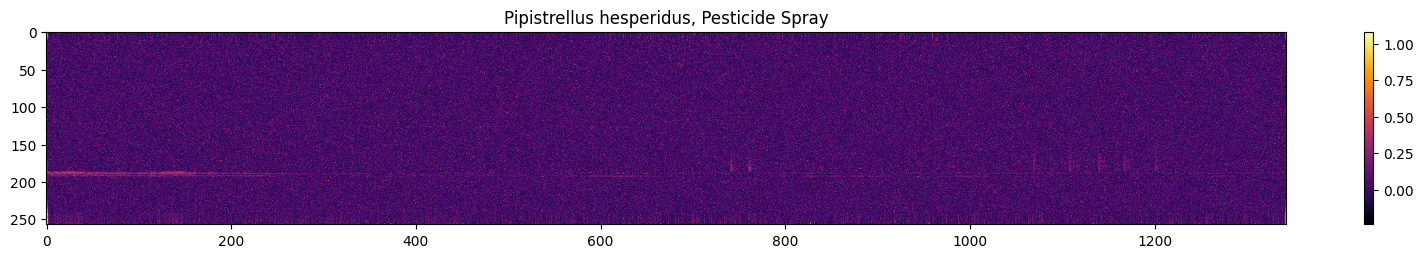

In [11]:
def plot_sequence(X, Y, k):
    plt.figure(figsize = (20, 2.5))
    x = X[k].cpu().detach().numpy()
    y = Y[k].cpu().detach().numpy()
    plt.imshow(np.rot90(x), interpolation='nearest', aspect='auto', cmap='inferno')
    plt.colorbar()
    label_list = []
    if(len(y.shape) > 0):
        for i in np.argwhere(y == 1)[:,0]:
            label_list.append(list(classes)[i])
        plt.title(", ".join(label_list))
    else:
        plt.title(list(classes)[y])
    print(x.shape)

k = np.random.randint(0, batch_size)
X1, Y1 = next(iter(train_loader))
X1, Y1 = X1.cuda(), Y1.cuda()
X1, Y1 = mixup(X1, Y1, min_seq=1, max_seq=3)
X1 = preprocess(X1)
X1 = noise(X1)
#X1 = freq_masking(X1)
#X1 = time_masking(X1)
        
plot_sequence(X1, Y1, k)

In [12]:
criterion = AsymmetricLoss(gamma_neg=2, gamma_pos=1, clip=0)

#base_optimizer = torch.optim.SGD
#optimizer = SAM(model.parameters(), base_optimizer, lr=lr, momentum=0.9)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer.base_optimizer, T_0=warmup_epochs)

optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4, nesterov=True, dampening=0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=warmup_epochs)

min_val_loss = np.inf

torch.autograd.set_detect_anomaly(True)

In [13]:
def smoothen(y, num_classes, l=.02):
    return y * (1.0 - l) + (y.sum(dim=1, keepdim=True) * l / num_classes).repeat(1, num_classes)

def getSpeciesMasks(species):
    masks = torch.eye(len(species))
    for i, s in enumerate(species):
        genus = s.split(' ')[0]
        for k, ss in enumerate(species):
            if ss.startswith(genus):
                masks[i, k] = 1
        masks[i, i] = 0
    return masks

def speciesSmoothing(Y, masks, l=.1):
    ny = torch.zeros_like(Y)
    for i, y in enumerate(Y):
        lbl = torch.nonzero(y)
        ny[i] = y * (1.0 - l) + masks[lbl].sum(0) * (y.sum() * l / max(masks[lbl].sum(), 1))
    return ny

'''test_y = torch.zeros(3, num_classes).to(device)
test_y[0, 4] = 1
test_y[0, 5] = 1
test_y[1, 11] = 1
test_y[2, 4] = 1
test_y[2, 11] = 1
test_y[2, 17] = 1
print(test_y)
masks = getSpeciesMasks(list(classes)).to(device)
test_smooth = smoothen(test_y, num_classes)
test_specsmooth = speciesSmoothing(test_y, masks)
print(test_smooth, test_smooth.sum())
print(test_specsmooth, test_specsmooth.sum())'''

'test_y = torch.zeros(3, num_classes).to(device)\ntest_y[0, 4] = 1\ntest_y[0, 5] = 1\ntest_y[1, 11] = 1\ntest_y[2, 4] = 1\ntest_y[2, 11] = 1\ntest_y[2, 17] = 1\nprint(test_y)\nmasks = getSpeciesMasks(list(classes)).to(device)\ntest_smooth = smoothen(test_y, num_classes)\ntest_specsmooth = speciesSmoothing(test_y, masks)\nprint(test_smooth, test_smooth.sum())\nprint(test_specsmooth, test_specsmooth.sum())'

In [14]:
model.load_state_dict(torch.load('BigBAT-best-baseline.pth'))

<All keys matched successfully>

In [15]:
import torchvision.transforms as T
import random

class RandomApply(nn.Module):
    def __init__(self, fn, p):
        super().__init__()
        self.fn = fn
        self.p = p
    def forward(self, x):
        if random.random() > self.p:
            return x
        return self.fn(x)

augment_s = nn.Sequential(
    #RandomApply(T.ColorJitter(0.8, 0.8, 0.8, 0.2), p=0.8),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    RandomApply(T.GaussianBlur((23, 23), (1.5, 1.5)), p=0.3),
    RandomApply(noise, p=0.5),
    T.RandomErasing()
    #T.RandomResizedCrop((1343, 257))
)

augment_w = nn.Sequential(
    #RandomApply(T.ColorJitter(0.8, 0.8, 0.8, 0.2), p=0.8),
    #T.RandomHorizontalFlip(),
    #T.RandomVerticalFlip(),
    RandomApply(T.GaussianBlur((23, 23), (1.5, 1.5)), p=0.3),
    RandomApply(noise, p=0.5),
    #T.RandomErasing()
    #T.RandomResizedCrop((1343, 257))
)

def ce_loss(logits, targets, use_hard_labels=True, reduction='none'):
    """
    wrapper for cross entropy loss in pytorch.
    
    Args
        logits: logit values, shape=[Batch size, # of classes]
        targets: integer or vector, shape=[Batch size] or [Batch size, # of classes]
        use_hard_labels: If True, targets have [Batch size] shape with int values. If False, the target is vector (default True)
    """
    if use_hard_labels:
        return nn.functional.cross_entropy(logits, targets, reduction=reduction)
    else:
        assert logits.shape == targets.shape
        log_pred = nn.functional.log_softmax(logits, dim=-1)
        nll_loss = torch.sum(-targets*log_pred, dim=1)
        return 
    
def consistency_loss(logits_w, logits_s, name='ce', T=1.0, p_cutoff=0.5, use_hard_labels=True, criterion=None):
    assert name in ['ce', 'L2', 'L2_mask', 'custom_mask']
    logits_w = logits_w.detach()
    if name == 'L2':
        assert logits_w.size() == logits_s.size()
        return nn.functional.mse_loss(logits_s, logits_w, reduction='mean')
    
    elif name == 'L2_mask':
        logits_w = logits_w.detach()
        outputs_pseudo = torch.sigmoid(logits_w)
        max_probs, pseudo_labels = torch.max(outputs_pseudo, 1)
        pseudo_labels = torch.nn.functional.one_hot(pseudo_labels, num_classes).to(torch.float32)
        mask = max_probs.ge(p_cutoff)
        masked_loss = nn.functional.mse_loss(logits_s[mask], pseudo_labels[mask])
        return masked_loss

    elif name == 'custom_mask':
        logits_w = logits_w.detach()
        outputs_pseudo = torch.sigmoid(logits_w)
        max_probs, pseudo_labels = torch.max(outputs_pseudo, 1)
        pseudo_labels = torch.nn.functional.one_hot(pseudo_labels, num_classes).to(torch.float32)
        mask = max_probs.ge(p_cutoff)
        masked_loss = criterion(logits_s[mask], pseudo_labels[mask])
        return masked_loss
    
    elif name == 'ce':
        pseudo_label = torch.softmax(logits_w, dim=-1)
        max_probs, max_idx = torch.max(pseudo_label, dim=-1)
        mask = max_probs.ge(p_cutoff).float()
        
        if use_hard_labels:
            masked_loss = ce_loss(logits_s, max_idx, use_hard_labels, reduction='none') * mask
        else:
            pseudo_label = torch.softmax(logits_w/T, dim=-1)
            masked_loss = ce_loss(logits_s, pseudo_label, use_hard_labels) * mask
        return masked_loss.mean()

    else:
        assert Exception('Not Implemented consistency_loss')

In [16]:
lambda_u = 1.0

def train_epoch(model, epoch, criterion, optimizer, scheduler, dataloader, dataloader_u, device):
    model.train()
        
    num_batches = len(dataloader_u)
    num_samples = 0
    
    running_loss = 0.0
    running_corrects = 0

    iter_u = iter(dataloader_u)
        
    # Normal training procedure
    for batch, (inputs, labels) in enumerate(tqdm(dataloader)):
        try:
            inputs_u, _ = next(iter_u)
        except StopIteration:
            iter_u = iter(dataloader_u)
            inputs_u, _ = next(iter_u)
        
        inputs_u = inputs_u.to(device)
        inputs_u = preprocess(inputs_u)
        
        inputs, labels = inputs.to(device), labels.to(device)
        inputs, labels = mixup(inputs, labels, min_seq=1, max_seq=3)
        inputs = preprocess(inputs)

        # Augment unlabeled data (weakly and strongly)
        inputs_uw = augment_w(inputs_u)
        inputs_us = augment_s(inputs_u)
        
        #outputs_u = model(inputs_u[mask])
        outputs_uw = model(inputs_uw)
        outputs_us = model(inputs_us)
        unlabeled_loss = consistency_loss(outputs_uw, outputs_us, name='L2')
        
        outputs = model(inputs)
        labeled_loss = criterion(outputs, labels) # reduction : mean
        loss = labeled_loss + lambda_u * unlabeled_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate Loss
        running_loss += loss.item() * inputs.size(0)
        running_corrects += getCorrects(outputs, labels)
        num_samples += inputs.size(0)
    
        # Perform learning rate step
        scheduler.step(epoch + batch / num_batches)
            
    epoch_loss = running_loss / num_samples
    epoch_acc = running_corrects / num_samples
    return epoch_loss, epoch_acc

In [17]:
def test_epoch(model, epoch, criterion, optimizer, dataloader, device):
    model.eval()
    
    num_batches = len(dataloader)
    num_samples = len(dataloader.dataset)
    
    with torch.no_grad():
        running_loss = 0.0
        running_corrects = 0

        for batch, (inputs, labels) in enumerate(tqdm(dataloader)):
            # Transfer Data to GPU if available
            inputs, labels = inputs.to(device), labels.to(device)
            inputs, labels = mixup(inputs, labels, min_seq=1, max_seq=3)
            inputs = preprocess(inputs)

            # Clear the gradients
            optimizer.zero_grad()

            # Forward Pass
            outputs = model(inputs)

            # Compute Loss
            loss = criterion(outputs, labels)

            # Calculate Loss
            running_loss += loss.item() * inputs.size(0)
            running_corrects += getCorrects(outputs, labels)

        epoch_loss = running_loss / num_samples
        epoch_acc = running_corrects / num_samples
    
    return epoch_loss, epoch_acc

# Training

In [18]:
import wandb

wandb_config = {
    "epochs": epochs,
    "lr": lr,
    "batch_size": batch_size,
    "warmup_epochs": warmup_epochs,
    "d_model": d_model,
    "nhead": nhead,
    "dim_feedforward": dim_feedforward,
    "num_layers": num_layers,
    "dropout": dropout,
    "classifier_dropout": classifier_dropout
}

wandb.init(project="BigBAT-UFS", entity="frankfundel", config=wandb_config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: frankfundel. Use `wandb login --relogin` to force relogin


In [19]:
for epoch in range(epochs):
    end = time.time()
    print(f"==================== Starting at epoch {epoch} ====================", flush=True)

    train_loss, train_acc = train_epoch(model, epoch, criterion, optimizer, scheduler, train_loader,
                                        unlabeled_loader, device)
    print('Training loss: {:.4f} Acc: {:.4f}'.format(train_loss, train_acc), flush=True)

    val_loss, val_acc = test_epoch(model, epoch, criterion, optimizer, val_loader, device)
    print('Validation loss: {:.4f} Acc: {:.4f}'.format(val_loss, val_acc), flush=True)

    wandb.log({
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
    })

    if min_val_loss > val_loss:
        print('val_loss decreased, saving model', flush=True)
        min_val_loss = val_loss

        # Saving State Dict
        torch.save(model.state_dict(), 'BigBAT-FixMatch.pth')

==================== Starting at epoch 0 ====================


100%|██████████| 105/105 [01:03<00:00,  1.65it/s]

Training loss: 81.7966 Acc: 0.5623



100%|██████████| 60/60 [00:06<00:00,  8.81it/s]

Validation loss: 94.8486 Acc: 0.5588
val_loss decreased, saving model


==================== Starting at epoch 1 ====================


100%|██████████| 105/105 [00:52<00:00,  1.99it/s]

Training loss: 74.0294 Acc: 0.5920



100%|██████████| 60/60 [00:06<00:00,  8.97it/s]

Validation loss: 97.7866 Acc: 0.5804
==================== Starting at epoch 2 ====================



100%|██████████| 105/105 [00:56<00:00,  1.87it/s]

Training loss: 70.4498 Acc: 0.6281



100%|██████████| 60/60 [00:06<00:00,  8.94it/s]

Validation loss: 100.4947 Acc: 0.5507
==================== Starting at epoch 3 ====================



100%|██████████| 105/105 [00:55<00:00,  1.89it/s]

Training loss: 68.9146 Acc: 0.6301



100%|██████████| 60/60 [00:06<00:00,  8.96it/s]

Validation loss: 92.8582 Acc: 0.6197
val_loss decreased, saving model
==================== Starting at epoch 4 ====================



100%|██████████| 105/105 [00:56<00:00,  1.87it/s]

Training loss: 67.9003 Acc: 0.6411



100%|██████████| 60/60 [00:06<00:00,  8.92it/s]

Validation loss: 97.4112 Acc: 0.5817
==================== Starting at epoch 5 ====================



100%|██████████| 105/105 [00:54<00:00,  1.91it/s]

Training loss: 70.8071 Acc: 0.6283



100%|██████████| 60/60 [00:06<00:00,  8.88it/s]

Validation loss: 108.3053 Acc: 0.5818
==================== Starting at epoch 6 ====================



100%|██████████| 105/105 [00:54<00:00,  1.92it/s]

Training loss: 68.5734 Acc: 0.6416



100%|██████████| 60/60 [00:06<00:00,  8.81it/s]

Validation loss: 96.9480 Acc: 0.5969
==================== Starting at epoch 7 ====================



100%|██████████| 105/105 [00:53<00:00,  1.95it/s]

Training loss: 66.8708 Acc: 0.6611



100%|██████████| 60/60 [00:06<00:00,  8.90it/s]

Validation loss: 100.8952 Acc: 0.5525
==================== Starting at epoch 8 ====================



100%|██████████| 105/105 [00:55<00:00,  1.88it/s]

Training loss: 63.8742 Acc: 0.6693



100%|██████████| 60/60 [00:06<00:00,  8.83it/s]

Validation loss: 99.5097 Acc: 0.5956
==================== Starting at epoch 9 ====================



100%|██████████| 105/105 [00:54<00:00,  1.92it/s]

Training loss: 63.0898 Acc: 0.6815



100%|██████████| 60/60 [00:06<00:00,  8.84it/s]

Validation loss: 98.4884 Acc: 0.5958
==================== Starting at epoch 10 ====================



100%|██████████| 105/105 [00:55<00:00,  1.90it/s]

Training loss: 65.4625 Acc: 0.6679



100%|██████████| 60/60 [00:06<00:00,  8.85it/s]

Validation loss: 100.2646 Acc: 0.5732
==================== Starting at epoch 11 ====================



100%|██████████| 105/105 [00:55<00:00,  1.90it/s]

Training loss: 65.2370 Acc: 0.6685



100%|██████████| 60/60 [00:06<00:00,  8.88it/s]

Validation loss: 100.4095 Acc: 0.5548
==================== Starting at epoch 12 ====================



100%|██████████| 105/105 [00:53<00:00,  1.95it/s]

Training loss: 63.0796 Acc: 0.6858



100%|██████████| 60/60 [00:06<00:00,  8.89it/s]

Validation loss: 101.7617 Acc: 0.5804
==================== Starting at epoch 13 ====================



100%|██████████| 105/105 [00:55<00:00,  1.88it/s]

Training loss: 60.0534 Acc: 0.6975



100%|██████████| 60/60 [00:06<00:00,  8.81it/s]

Validation loss: 98.3848 Acc: 0.6081
==================== Starting at epoch 14 ====================



100%|██████████| 105/105 [00:53<00:00,  1.96it/s]

Training loss: 59.2671 Acc: 0.7024



100%|██████████| 60/60 [00:06<00:00,  8.89it/s]

Validation loss: 98.6745 Acc: 0.5856


In [20]:
# Load after training
model.load_state_dict(torch.load('BigBAT-FixMatch.pth'))

<All keys matched successfully>

# Evaluation

In [ ]:
mixed_corrects = 0.0
repeats = 5

predictions = []
targets = []

for r in range(repeats):
    # iterate over test data
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs, labels = mixup(inputs, labels, min_seq=1, max_seq=3)
        inputs = preprocess(inputs)

        output = model(inputs) # Feed Network
        predictions.extend(output.data.cpu().numpy())
        targets.extend(labels.data.cpu().numpy())
        mixed_corrects += getCorrects(output, labels)

 83%|████████▎ | 68/82 [00:07<00:01,  9.34it/s]

In [ ]:
from sklearn.metrics import f1_score

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

mixed_test_acc = mixed_corrects / (repeats * len(test_data))
mixed_f1_micro = f1_score(sigmoid(np.asarray(predictions)) > 0.5, np.asarray(targets), average='micro')
mixed_f1_macro = f1_score(sigmoid(np.asarray(predictions)) > 0.5, np.asarray(targets), average='macro')

print("Mixed test acc:", mixed_test_acc)
print("Mixed f1 micro:", mixed_f1_micro)
print("Mixed f1 macro:", mixed_f1_macro)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params, "params")

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn
import pandas as pd

Y_pred = []
Y_true = []

model.eval()

# iterate over test data
for inputs, labels in tqdm(test_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    inputs = preprocess(inputs)
    
    output = model(inputs) # Feed Network

    output = (output > 0.5).data.cpu().numpy()
    Y_pred.extend(output) # Save Prediction

    #labels = torch.argmax(labels, 1).data.cpu().numpy()
    labels = labels.data.cpu().numpy()
    Y_true.extend(labels) # Save Truth

In [ ]:
cf_matrix = multilabel_confusion_matrix(Y_true, Y_pred)

f, axes = plt.subplots(2, 5, figsize=(25, 10))
axes = axes.ravel()
for i in range(len(classes_list)):
    disp = ConfusionMatrixDisplay(cf_matrix[i] / np.sum(cf_matrix[i]), display_labels=[0, i])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(classes_list[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

In [ ]:
# Filter out mixed
Y_pred2 = []
Y_true2 = []
for i, y in enumerate(Y_true):
    if y.sum() == 1:
        Y_true2.append(np.argmax(y))
        Y_pred2.append(np.argmax(Y_pred[i]))
Y_pred = Y_pred2
Y_true = Y_true2

In [ ]:
corrects = np.equal(Y_pred, Y_true).sum()
single_test_acc = corrects / len(Y_pred)
single_f1 = f1_score(Y_true, Y_pred, average=None).mean()

print("Single test accuracy:", single_test_acc)
print("Single F1-score:", single_f1)

In [ ]:
wandb.log({
    "mixed_test_acc": mixed_test_acc,
    "mixed_f1_micro": mixed_f1_micro,
    "mixed_f1_macro": mixed_f1_macro,
    "single_test_acc": single_test_acc,
    "single_f1_micro": single_f1,
    "num_params": pytorch_total_params,
})

wandb.finish()